# Visualizing harmful PM<sub>2.5</sub> levels in the US by county

In [2]:
# %pip install pandas geopandas folium matplotlib mapclassify

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
# download the data from US NIH (https://hdpulse.nimhd.nih.gov/data-portal/physical/table?age=001&age_options=ageall_1&demo=234&demo_options=air_pollution_1&physicaltopic=002&physicaltopic_options=physical_2&race=00&race_options=raceall_1&sex=0&sex_options=sexboth_1&statefips=99&statefips_options=area_states)

county_pm25: pd.DataFrame = pd.read_csv(
    "HDPulse_data_export.csv",
    skiprows=5,
)

In [5]:
county_pm25

,County,FIPS,Micrograms per cubic meter (PM2.5)(2)
0,United States,0.0,7.4
1,"San Bernardino County, California",6071.0,15.6
2,"Fairbanks North Star, Alaska",2090.0,15.5
3,"Allegheny County, Pennsylvania",42003.0,14.1
4,"San Diego County, California",6073.0,13.8
...,...,...,...
3146,Notes:,NaN,NaN
3147,Source: National Environmental Public Health T...,NaN,NaN
3148,Average daily density of fine particulate matt...,NaN,NaN
3149,Some data are not available or suppressed due ...,NaN,NaN


In [6]:
county_pm25_processed: pd.DataFrame = (
    county_pm25.assign(
        # make PM2.5 reading a float
        pm25_ug_per_m3=lambda x: pd.to_numeric(arg=x[x.keys()[-1]], errors="coerce"),
        # convert FIPS to a 5-digit string
        FIPS=lambda x: pd.to_numeric(x["FIPS"]),
    )
    .dropna(
        # drop rows with missing PM2.5 readings
        subset=[
            "FIPS",
            "pm25_ug_per_m3",
        ],
    )
    .assign(
        FIPS=lambda x: x["FIPS"].astype(int).astype(str).str.zfill(5),
    )
)

In [7]:
# optional sense check
county_pm25_processed

,County,FIPS,Micrograms per cubic meter (PM2.5)(2),pm25_ug_per_m3
0,United States,00000,7.4,7.4
1,"San Bernardino County, California",06071,15.6,15.6
2,"Fairbanks North Star, Alaska",02090,15.5,15.5
3,"Allegheny County, Pennsylvania",42003,14.1,14.1
4,"San Diego County, California",06073,13.8,13.8
...,...,...,...,...
3111,"Custer County, South Dakota",46033,2.6,2.6
3112,"Apache County, Arizona",04001,2.5,2.5
3113,"Campbell County, Wyoming",56005,2.4,2.4
3114,"Converse County, Wyoming",56009,2.2,2.2


In [8]:
# download us county shape files from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
counties: gpd.GeoDataFrame = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip"
)

In [9]:
counties_processed: gpd.GeoDataFrame = counties.assign(
    FIPS=lambda x: x["STATEFP"] + x["COUNTYFP"],
)

In [10]:
# optional sense check
counties_processed

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,FIPS
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530...",21007
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283...",21017
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",21031
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461...",21065
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",21069
...,...,...,...,...,...,...,...,...,...,...,...
3228,31,073,00835858,0500000US31073,31073,Gosper,06,1186616237,11831826,"POLYGON ((-100.0951 40.43866, -100.08937 40.43...",31073
3229,39,075,01074050,0500000US39075,39075,Holmes,06,1094405866,3695230,"POLYGON ((-82.22066 40.66758, -82.19327 40.667...",39075
3230,48,171,01383871,0500000US48171,48171,Gillespie,06,2740719114,9012764,"POLYGON ((-99.304 30.49983, -99.28234 30.49967...",48171
3231,55,079,01581100,0500000US55079,55079,Milwaukee,06,625440563,2455383635,"POLYGON ((-88.06959 42.86726, -88.06959 42.872...",55079


In [11]:
# merge the two dataframes
counties_w_pm25 = counties_processed.merge(
    right=county_pm25_processed,
    on="FIPS",
    how="left",
)

In [12]:
# optional sense check
counties_w_pm25.STATEFP.unique()

array(['21', '17', '18', '01', '02', '05', '06', '08', '09', '11', '12',
       '13', '15', '16', '19', '20', '48', '29', '30', '31', '53', '22',
       '23', '24', '34', '35', '36', '37', '38', '39', '40', '49', '41',
       '42', '45', '46', '47', '25', '26', '51', '72', '78', '27', '28',
       '32', '33', '04', '54', '55', '56', '60', '69', '50', '10', '44',
       '66'], dtype=object)

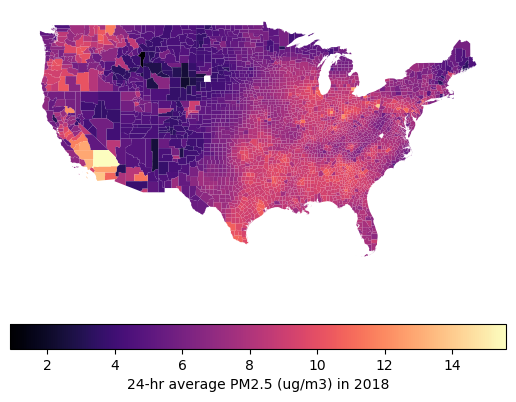

In [ ]:
# display PM2.5 in Contiguous US
ax = counties_w_pm25.pipe(
    lambda x: x[
        (x["STATEFP"].astype(int) <= 56) & ~(x["STATEFP"].astype(int).isin([2, 15]))
    ]
).plot(
    column="pm25_ug_per_m3",
    legend=False,
    cmap="magma",
)
ax.set_axis_off()


# Customize the colorbar
plt.colorbar(
    ax.collections[0],
    orientation="horizontal",
    label="24-hr average PM2.5 (ug/m3) in 2018",
)

plt.show()

In [14]:
# display the data on map by level of PM2.5
m = counties_w_pm25.explore(
    column="pm25_ug_per_m3",
)